#Pythonize AMBER suite

In [1]:
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = 'retina'  # high resolution
import matplotlib
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi'] # larger image
from matplotlib import pyplot as plt

In [3]:
import pytraj
import sander
from pytraj import io as mdio

No module named 'pytz'


#Pytraj

##post processing trajectory with pysander and pytraj

[-466.10420332687943, -455.5976464241175, -448.8931420795517, -450.3030628951594, -443.75073691232376]


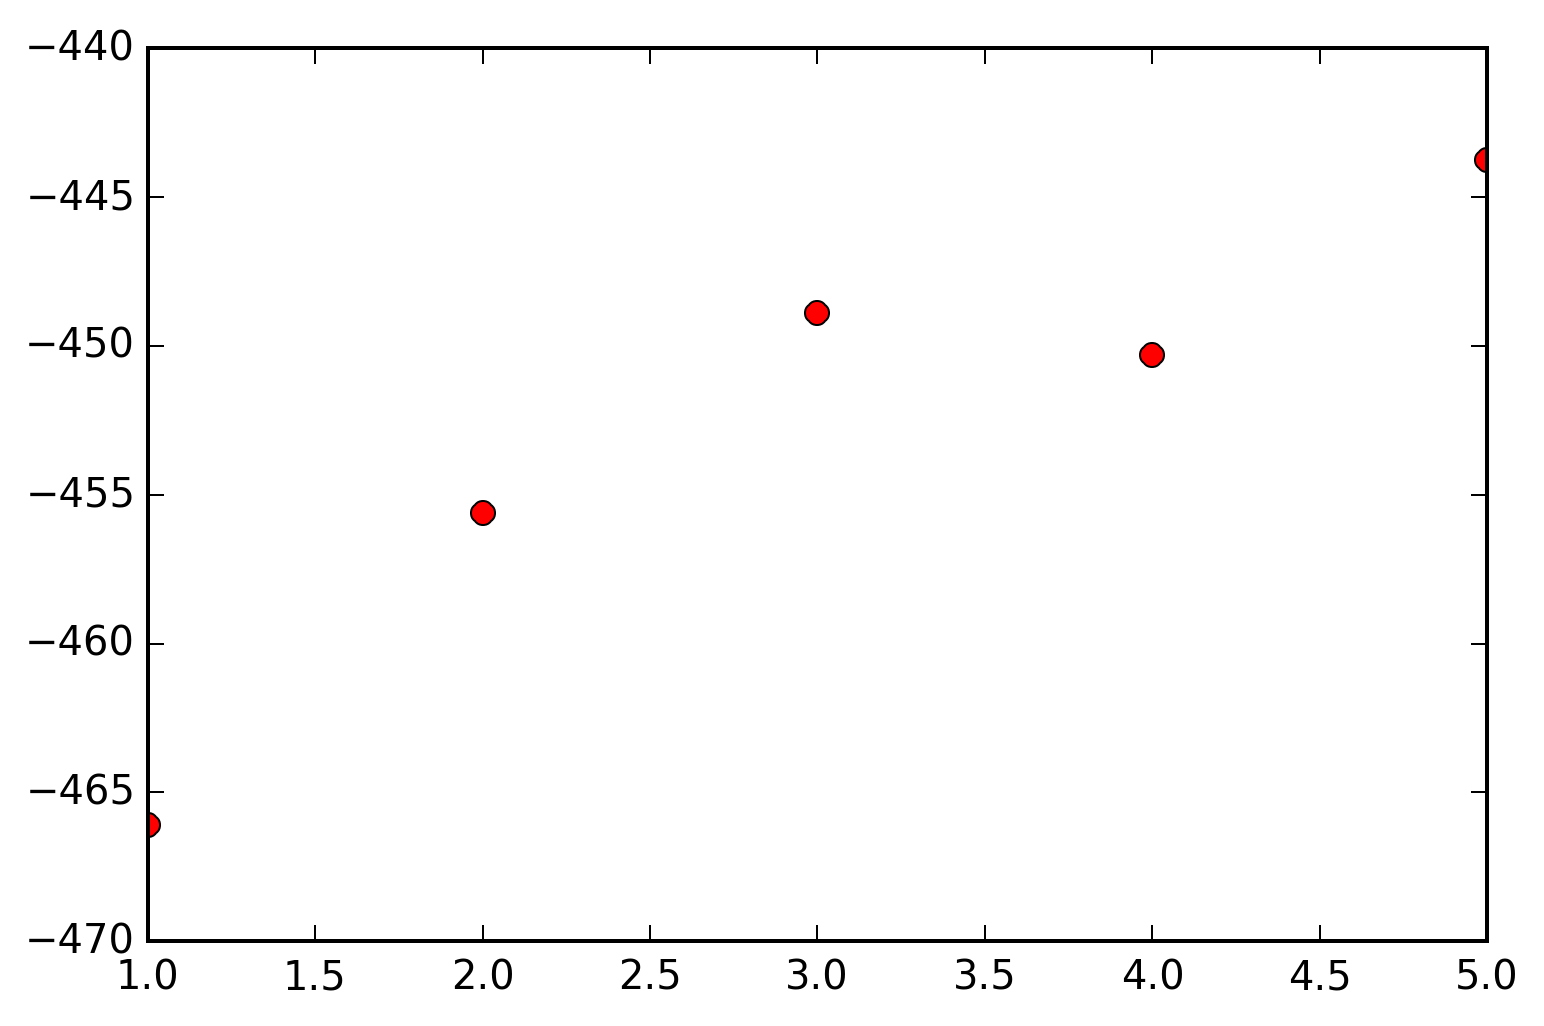

In [4]:
import chemistry as chem

traj_fn = "../tests/data/md1_prod.Tc5b.x"
top_fn = "../tests/data/Tc5b.top"

# load parm from `chemistry` package
parm = chem.load_file(top_fn)

# load  traj from `pytraj`
# load traj
traj = mdio.load(traj_fn, top_fn)

# initialize parm
parm.load_coordinates(traj[0].coords)

# create input for igb=8 model
inp = sander.gas_input(8)

egb = []
with sander.setup(parm, parm.coords, None, inp):
    # use traj(0, 8, 2) to read the traj from 0-th frame to 8-th frame but skiping every 2 frames
    for frame in traj(0, 8, 2):
        sander.set_positions(frame.coords)
        ene, forces = sander.energy_forces()
        
        # get GB energies
        egb.append(ene.gb)
        
# plotting
print (egb)
x_axis = [i+1 for i in range(len(egb))]
plt.plot(x_axis, egb, 'ro')

##easy to extract coordinates of specific mask

In [5]:
traj[':1-5@CA'][:2]

<Trajectory with 2 frames, 5 atoms/frame>
           

##easy to strip atoms

In [6]:
traj[':1-5@CA :frame'][:2]

<Trajectory with 2 frames, 5 atoms/frame>
           

##easy to 'talk' to other package: mdtraj

In [7]:
import mdtraj as md
import mdtraj.testing
from pytraj.io import load_mdtraj
from pytraj import DataSetList
dslist = DataSetList()

traj_filename = mdtraj.testing.get_fn('frame0.h5')
# load mdtraj trajectory object
m_traj = md.load(traj_filename)

# expose to `pytraj`
my_traj = load_mdtraj(m_traj)
print (m_traj)
print (my_traj)

No module named 'pytz'
<mdtraj.Trajectory with 501 frames, 22 atoms, 3 residues, and unitcells>
<Trajectory with 501 frames, 22 atoms/frame>
           


##easy to 'talk' to other package: numpy

In [8]:
import numpy as np

frame = traj[0]

arr0 = np.asarray(frame[:])
print (frame.shape)
print (arr0.shape)

# change x-coord of all atoms to 0.0 (dummy example)
arr0[:, 0] = np.zeros(traj.n_atoms)
print (frame[:, 0])

(304, 3)
(304, 3)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0. 

##easy to construct Trajectory and save to different file formats

In [9]:
from pytraj import Trajectory
import pytraj.io as io

# load xyz coordinates from ParmEd package
frame_array = Trajectory(parm.coords, traj.top)
print (frame_array)
io.save("my_charmming.dcd", frame_array, frame_array.top, overwrite=True)

<Trajectory with 1 frames, 304 atoms/frame>
           


In [10]:
!ls my_charmming.dcd

my_charmming.dcd


#Future

###this code does not exist yet (it's really **hurt** to try)

    import nab
    from pmemd import run_min_gpu
    import leap

    frame = nab.build_nu(sequence="GCGC", build_type='dna double')
    top = leap.build_top(frame, forcefield='bsc0')
    new_frame = run_min_gpu(frame)